In [124]:
import tensorflow as tf
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Dense, Input, Dropout, Flatten
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import math
import os
import random
from joblib import dump, load
import gzip
import msgpack
import sys
from sklearn.metrics import accuracy_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.utils import resample
from imblearn.over_sampling import SMOTE
from sklearn.tree import DecisionTreeClassifier
import copy

In [125]:
df = pd.DataFrame()
for i in range(1, 11):
    df1 = pd.DataFrame()
    df1 = pd.read_csv(f'/content/drive/MyDrive/BTP-DataSets/MHEALTHDATASET/mHealth_subject{i}.log', header=None, sep='\t')
    df1 = df1.rename(columns={0: "acx", 1: "acy", 2: "acz", 3: "es1", 4: "es2",
                              5: "alx", 6: "aly", 7: "alz", 8: "glx", 9: "gly", 10: "glz", 11: "mlx", 12: "mly",
                              13: "mlz", 14: "arx", 15: "ary", 16: "arz", 17: "grx", 18: "gry", 19: "grz", 20: "mrx",
                              21: "mry", 22: "mrz", 23: "Activity"})
    df = pd.concat([df, df1])

<Axes: >

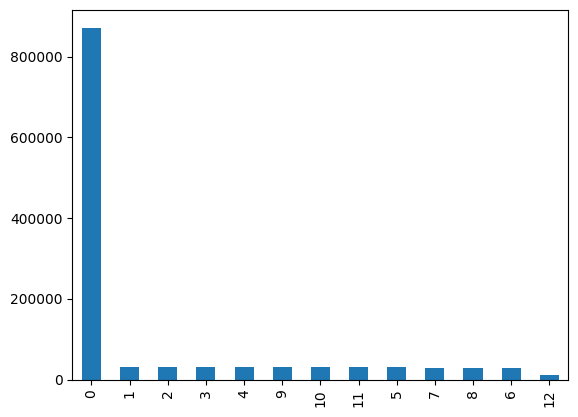

In [126]:
pd.value_counts(df['Activity']).plot.bar()

In [127]:
from sklearn.utils import resample

df_majority = df[df.Activity==0]
df_minorities = df[df.Activity!=0]

df_majority_downsampled = resample(df_majority,n_samples=30000, random_state=50)
df = pd.concat([df_majority_downsampled, df_minorities])
df.Activity.value_counts()

1     30720
2     30720
3     30720
4     30720
9     30720
10    30720
11    30720
5     30720
0     30000
7     29441
8     29337
6     28315
12    10342
Name: Activity, dtype: int64

In [128]:
num_of_clusters = 5
clusters_df=[]
for _ in range(num_of_clusters):
    clusters_df.append(df.sample(100000, replace=False))
cluster_heads=np.array([-1,-1,-1,-1,-1])

In [129]:
workers_info=[]
enery_for_edge_at_start=100000
#data,cluster no ,edge score,model - coeff,model -intercept,energy consumed,acc
for i in range(5):
    for j in range(5):
        worker_data=pd.DataFrame(clusters_df[i].sample(30000, replace=False))
        worker_id=i
        worker_score=0
        worker_coef=0
        worker_intercept=0
        worker_energy=[]
        energy_acc=[]
        energy=enery_for_edge_at_start
        workers_info.append([worker_data,worker_id,worker_coef,worker_score,worker_intercept,worker_energy,energy_acc,energy])

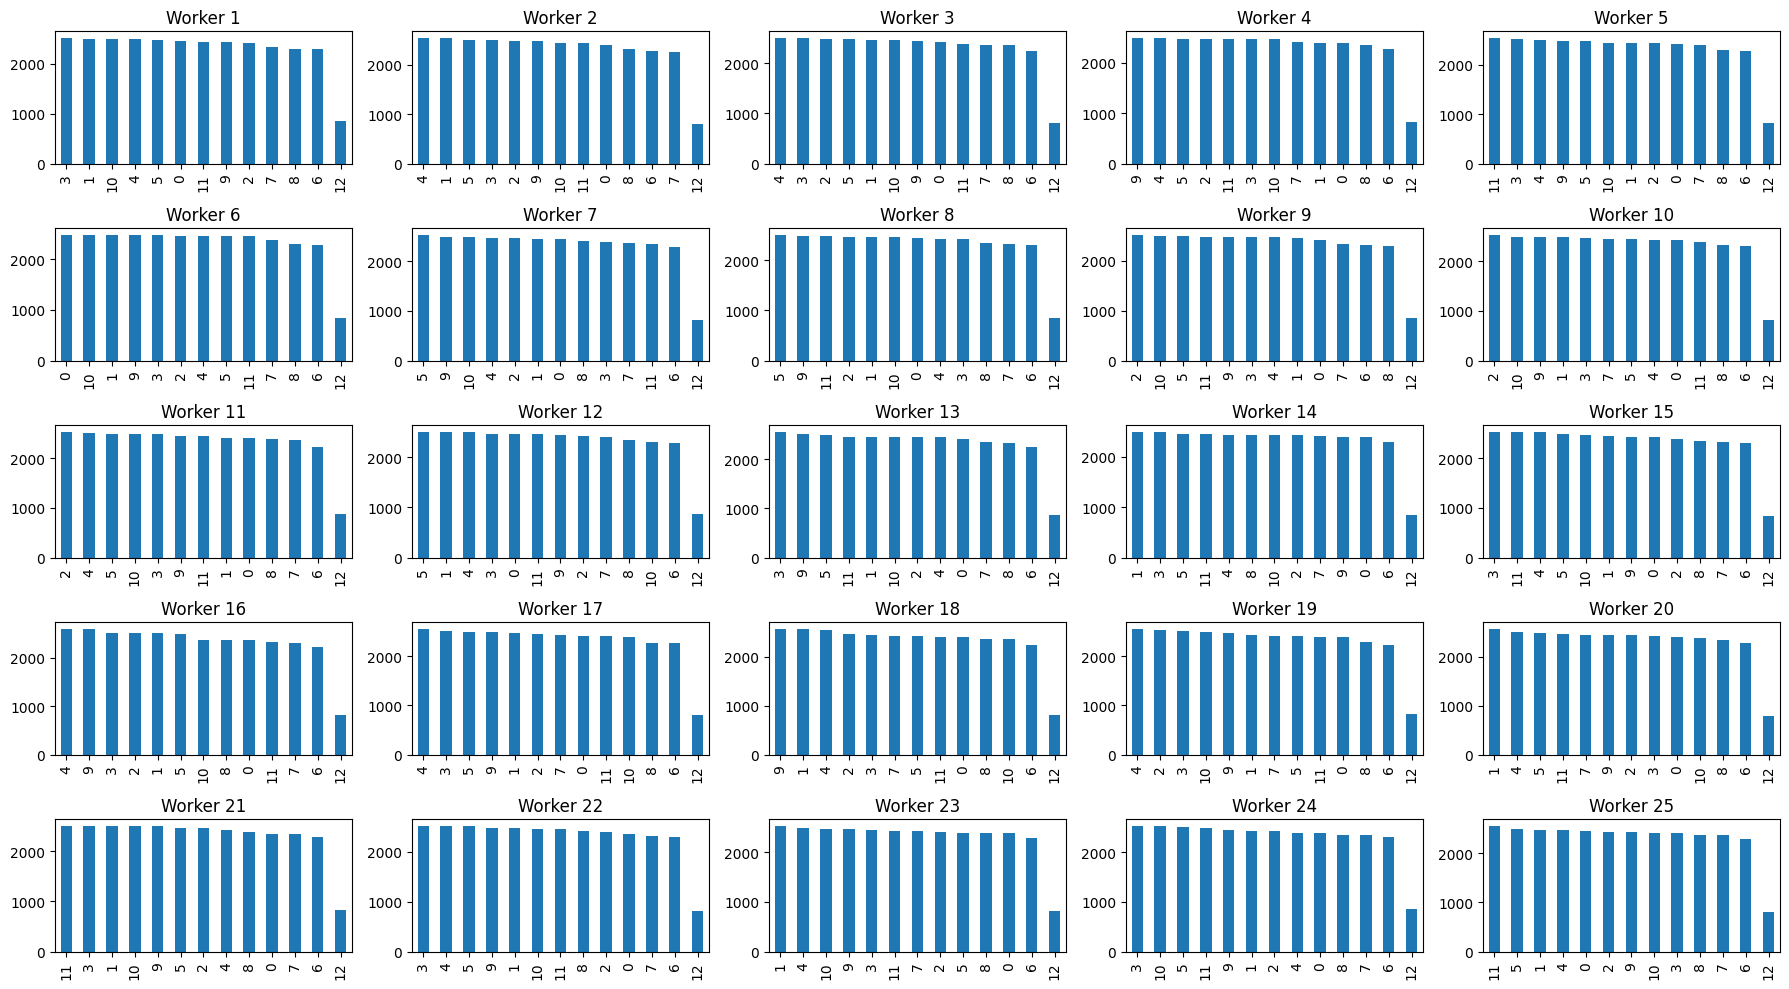

In [130]:
fig = plt.figure(figsize=(18, 10))
for i, worker in enumerate(workers_info):
    ax = fig.add_subplot(5, 5, i + 1)
    pd.value_counts(worker[0]['Activity']).plot.bar(ax=ax)
    ax.set_title(f'Worker {i + 1}')
fig.tight_layout()
plt.show()


In [131]:
max_rounds = 100  # Maximum number of training rounds
req_accuracy = 0.80  # Minimum accuracy threshold
negligible_change = 0.0001  # Change in accuracy to be considered negligible
energy_for_each_iteration=0.01
num_of_workers=25
def energy_for_transmit(data):
    power=1
    #energy=power *time=time=data/power=data
    return data
def terminate(accuracy,best_accuracy):
    if accuracy >= req_accuracy or abs(accuracy - best_accuracy) < negligible_change:
        return True
    return False

# Modify the local_worker_training function
def local_worker_training(worker_num, global_model):
    ltrain, ltest = train_test_split(workers_info[worker_num][0], test_size=0.2, random_state=42)
    lX_train = ltrain.drop('Activity', axis=1)
    ly_train = ltrain['Activity']
    lX_test = ltest.drop('Activity', axis=1)
    ly_test = ltest['Activity']

    model = RandomForestClassifier(n_estimators=100, random_state=42)

    # Initialize variables before the if-else block
    energy_comsuption_in_local = 0

    if worker_num in cluster_heads and workers_info[worker_num][2] is not None:
        energy_comsuption_in_local = energy_for_transmit(sys.getsizeof(workers_info[worker_num][5]) + sys.getsizeof(workers_info[worker_num][6]))

        # If the global model coefficients are available, set them during training
        sample_weights, _ = extract(workers_info[worker_num][2])
        print(f"Debug: Worker {worker_num}, sample_weights: {sample_weights}")
        if sample_weights is not None:
            sample_weights = np.ones(len(lX_train)) if sample_weights.size != len(lX_train) else sample_weights
            model.fit(lX_train, ly_train, sample_weight=sample_weights)
        else:
            model.fit(lX_train, ly_train)

        workers_info[worker_num][2] = model  # Assign the trained model directly

    else:
        model.fit(lX_train, ly_train)

    accuracy = model.score(lX_test, ly_test)

    energy_comsuption_in_local += max_global_rounds * energy_for_each_iteration
    workers_info[worker_num][5].append(energy_comsuption_in_local)
    workers_info[worker_num][6].append(accuracy)
    workers_info[worker_num][7] -= energy_comsuption_in_local

    print("local worker:", worker_num, "acc:", accuracy, "round no:", max_global_rounds, "energy remaining:", workers_info[worker_num][7])


In [132]:
def training_workers(global_model=None):
    for i in range(num_of_workers):
        local_worker_training(i, global_model)

In [133]:
def cal_batter_life(energy_rem):
    return (energy_rem / enery_for_edge_at_start) * 100

In [134]:
# Modify the cal_edge_score function
def cal_edge_score():
    w1=0.4
    w2=0.6
    for i in range(num_of_workers):
        workers_info[i][3]=w1*workers_info[i][6][-1]+w2*cal_batter_life(workers_info[i][7])


# Modify the cal_clusters_head function
def cal_clusters_head():
    for i in range(5):
        max_score_edge=i*5
        for j in range(1,5):
            if workers_info[i*5+j][3]>workers_info[max_score_edge][3]:
	            max_score_edge=i*5+j
        cluster_heads[i]=max_score_edge


In [135]:
def global_aggregation():
    # Use RandomForestClassifier instead of SGDClassifier
    global_model = RandomForestClassifier(n_estimators=100, random_state=42)

    # Initialize a list to store aggregated models
    aggregated_models = []

    num_contributing_workers = 0

    for i in range(num_of_clusters):
        worker_model = workers_info[i][2]

        if worker_model:
            aggregated_models.append(worker_model)
            num_contributing_workers += 1

    # If there are contributing workers, aggregate their predictions
    if num_contributing_workers > 0:
        def aggregated_predict(X):
            predictions = [model.predict(X) for model in aggregated_models]
            return np.mean(predictions, axis=0)

        global_model.predict = aggregated_predict

    return global_model


In [136]:
def aggregate_tree_nodes(tree1, tree2):
    # Perform aggregation of nodes for two trees
    # You may need to customize this based on your specific requirements
    # This is a simple example assuming addition of node values
    tree1.values += tree2.values

    # Recursively aggregate left and right subtrees
    if tree1.children_left[0] != tree1.children_right[0]:
        tree1.children_left = aggregate_tree_nodes(tree1.children_left, tree2.children_left)
        tree1.children_right = aggregate_tree_nodes(tree1.children_right, tree2.children_right)

    return tree1

In [137]:
max_global_rounds = 15
acc = []

for i in range(max_global_rounds):
    global_model = global_aggregation()

    temp_max_acc = 0
    for j in range(num_of_workers):
        # Ensure there are enough recorded accuracies for each worker
        if len(workers_info[j][6]) > i and workers_info[j][6][i] is not None:
            workers_info[j][2] = global_model
            temp_max_acc = max(temp_max_acc, workers_info[j][6][i])

            # Additional debugging information
            print(f"local worker: {j} acc: {workers_info[j][6][i]} round no: {i} energy remaining: {workers_info[j][7]}")

    acc.append(temp_max_acc)
    print("round - global", i, "acc", temp_max_acc)

round - global 0 acc 0
round - global 1 acc 0
round - global 2 acc 0
round - global 3 acc 0
round - global 4 acc 0
round - global 5 acc 0
round - global 6 acc 0
round - global 7 acc 0
round - global 8 acc 0
round - global 9 acc 0
round - global 10 acc 0
round - global 11 acc 0
round - global 12 acc 0
round - global 13 acc 0
round - global 14 acc 0


In [332]:
total_energy_per_round=[]
energy_per_round=[]
total_energy=0
for i in range(15):
    energy=0
    for j in range(num_of_workers):
        total_energy+=workers_info[j][5][i]
        energy+=workers_info[j][5][i]
    energy_per_round.append(energy)
    total_energy_per_round.append(total_energy)
energy_per_round

IndexError: list index out of range

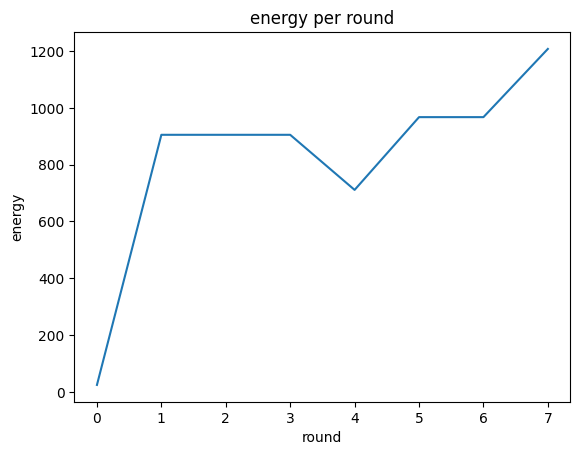

In [355]:
plt.plot(energy_per_round)
plt.xlabel("round")
plt.ylabel("energy")
plt.title("energy per round")
plt.show()

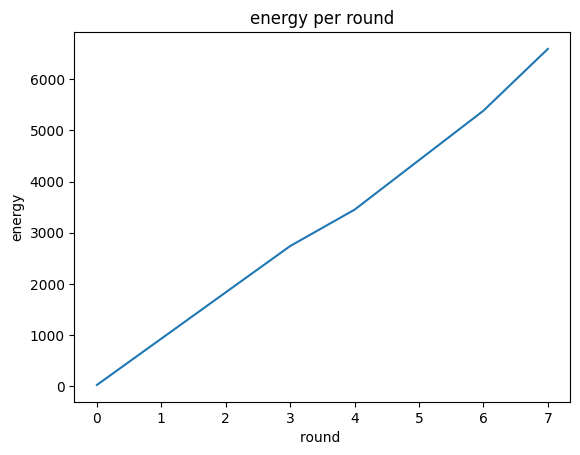

In [356]:
plt.plot(total_energy_per_round)
plt.xlabel("round ")
plt.ylabel("energy")
plt.title("energy per round")
plt.show()